In [1]:
import warnings

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm

from pymc_marketing.mmm import GeometricAdstock, LogisticSaturation
from pymc_marketing.mmm.MultiDimensionalMMM import VanillaMultiDimensionalMMM

In [2]:
warnings.filterwarnings("ignore", category=FutureWarning)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

In [3]:
VanillaMultiDimensionalMMM?

Init signature:
VanillaMultiDimensionalMMM(
    date_column: str,
    channel_columns: list[str],
    target_column: str,
    adstock: pymc_marketing.mmm.components.adstock.AdstockTransformation,
    saturation: pymc_marketing.mmm.components.saturation.SaturationTransformation,
    time_varying_intercept: bool = False,
    time_varying_media: bool = False,
    dims: tuple | None = None,
    model_config: dict | None = None,
    sampler_config: dict | None = None,
    validate_data: bool = True,
    control_columns: list[str] | None = None,
    yearly_seasonality: int | None = None,
    adstock_first: bool = True,
) -> None
Docstring:      Docstring example.
Init docstring: Define the constructor method.
File:           ~/Documents/GitHub/pymc-marketing/pymc_marketing/mmm/MultiDimensionalMMM.py
Type:           type
Subclasses:     

In [4]:
GeometricAdstock

pymc_marketing.mmm.components.adstock.GeometricAdstock

In [5]:
mmm = VanillaMultiDimensionalMMM(
    date_column="date",
    target_column="target",
    channel_columns=["a", "b"],
    dims=("country",),
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
)

In [6]:
# Generate a date range
date_range = pd.date_range(start="2023-01-01", end="2023-01-10")

# Define countries and channels
countries = ["Venezuela", "Colombia", "Chile", "Argentina"]
channels = ["a", "b"]

# Create a DataFrame
data = []
for country in countries:
    for date in date_range:
        record = [date, country, *list(np.random.randint(100, 500, size=len(channels)))]
        data.append(record)

df = pd.DataFrame(data, columns=["date", "country", *channels])
df["target"] = df[channels].sum(axis=1) + np.random.randint(100, 500, size=len(df))
df.head()

,date,country,a,b,target
0,2023-01-01,Venezuela,293,238,849
1,2023-01-02,Venezuela,374,241,880
2,2023-01-03,Venezuela,479,380,1348
3,2023-01-04,Venezuela,346,315,1084
4,2023-01-05,Venezuela,411,393,1220


In [8]:
mmm.fit(X=df.drop(columns="target"), y=df.drop(columns=channels))

-init-
-end-


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, adstock_alpha, saturation_lam, saturation_beta, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

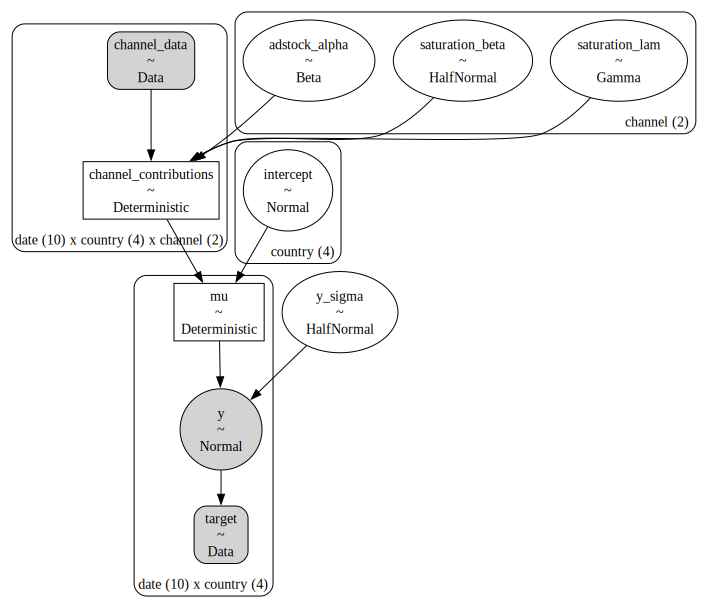

In [9]:
pm.model_to_graphviz(mmm.model)

In [10]:
mmm = VanillaMultiDimensionalMMM(
    date_column="date",
    target_column="target",
    channel_columns=["a", "b"],
    # dims=("country",),
    adstock=GeometricAdstock(l_max=8),
    saturation=LogisticSaturation(),
)

df.drop(columns="country", inplace=True)

In [11]:
mmm.fit(X=df.drop(columns="target"), y=df.drop(columns=channels))

-init-
-end-


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, adstock_alpha, saturation_lam, saturation_beta, y_sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
	> constant_data

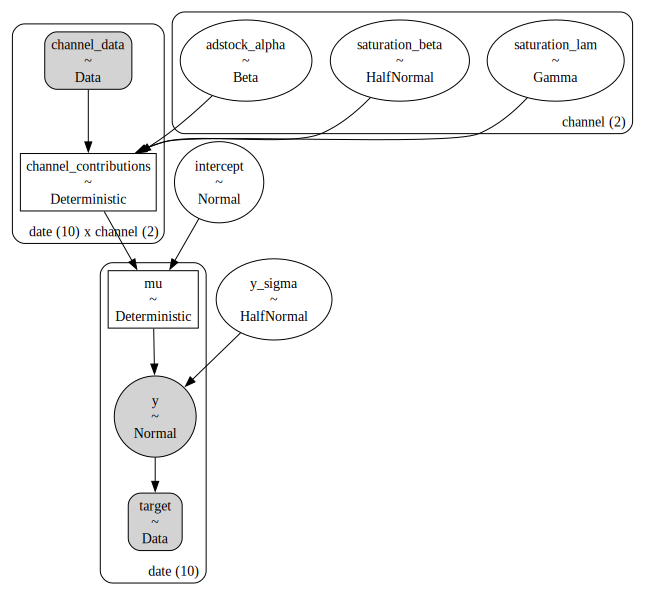

In [12]:
pm.model_to_graphviz(mmm.model)